## Paralog vs. singleton hemizygous deletions

In [1]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import random
from math import floor
import itertools
import re
import sys
sys.path.append("../1_data_processing")
import warnings
warnings.simplefilter("ignore")

import graphing_params as gp
import processing_utils as util
import analysis_utils as au
%load_ext autoreload
%autoreload 1
%aimport graphing_params
%aimport processing_utils
%aimport analysis_utils

get_data_path = lambda folders, fname: os.path.normpath(os.environ['THIRD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)
get_fig_path = lambda fname: os.path.normpath('../figures/' + fname)

file_annot_genes = get_local_data_path(['processed'], 'HGNC_gene_annot_ens93_hg19.csv')
file_chrom_info = get_local_data_path(['processed'], 'hg19_chrom_info.csv')

file_tcga_loh = get_local_data_path(['processed','TCGA','ASCAT'], 'LOH.csv')
file_icgc_loh = get_local_data_path(['processed','ICGC'], 'LOH.csv')

# Output
file_tcga_loh_map = get_local_data_path(['processed','TCGA','ASCAT'], 'LOH_map.csv')
#file_tcga_loh_map = get_local_data_path(['processed','TCGA','ASCAT'], 'LOH_map.csv')

### Load annotated genes + CCDS for those genes

In [2]:
genes = pd.read_csv(file_annot_genes)
passenger_genes = genes[~genes.TSG & ~genes.OG & ~genes.within_driver & ~genes.outside_bounds]
print('N genes:', genes.shape[0])
print('N passenger genes:', passenger_genes.shape[0])
print('Paralogs: %d = %.2f%%' % (sum(passenger_genes.paralog), 
                                 sum(passenger_genes.paralog)/passenger_genes.shape[0]*100))
display(genes[:1])

N genes: 17572
N passenger genes: 16898
Paralogs: 10588 = 62.66%


,symbol,entrez_id,ensembl_id,chr,cds_from,cds_to,ccds_id,cds_len,cds_mid,n_paralogs,...,depmap_ess,depmap_ess_cat,ess_gt,ess_3D,TSG_CGC,TSG_Bailey,TSG,OG,within_driver,outside_bounds
0,A1BG,1,ENSG00000121410,19,58858387,58864802,CCDS12976,6415,58861594.5,NaN,...,False,never,False,False,False,False,False,False,False,False


### Loss-of-Heterozygosity

### 1. TCGA

In [3]:
tcga_loh_segments = pd.read_csv(file_tcga_loh)

In [4]:
assert(tcga_loh_segments[~((tcga_loh_segments.nMinor==0) & (tcga_loh_segments.nMajor>=1))].shape[0]==0)

In [5]:
print('N samples w/ any LOH:', tcga_loh_segments['patient'].nunique())
display(tcga_loh_segments[:1])

N samples w/ any LOH: 9713


,name,patient,ploidy,chr,startpos,endpos,nMajor,nMinor,del_len
0,TCGA-02-0001,TCGA-02-0001,2.3329,1,74386991,75378041,2,0,991050


#### Annotate focal LOH (length <= 0.5 of arm length)

In [6]:
chrom_info = pd.read_csv(file_chrom_info)
chrom_info = chrom_info[~chrom_info.chr.isin(['X','Y'])].astype({'chr':int})
chrom_info['half_arm1_len'] = chrom_info['centStart'] * 0.5
chrom_info['half_arm2_len'] = (chrom_info['size'] - chrom_info['centEnd']) * 0.5
chrom_info[:1]

,chr,centStart,centEnd,size,half_arm1_len,half_arm2_len
0,1,121535434,124535434,249250621,60767717.0,62357593.5


In [7]:
tcga_loh_segments = pd.merge(tcga_loh_segments, chrom_info[['chr','centEnd','half_arm1_len','half_arm2_len']])
tcga_loh_segments['focal'] = tcga_loh_segments.apply(
    lambda x: x.del_len < x.half_arm1_len if x.endpos < x.centEnd else x.del_len < x.half_arm2_len, axis=1)
tcga_loh_segments = tcga_loh_segments.drop(columns=['centEnd','half_arm1_len','half_arm2_len'])

In [8]:
tcga_loh_segments[:1]

,name,patient,ploidy,chr,startpos,endpos,nMajor,nMinor,del_len,focal
0,TCGA-02-0001,TCGA-02-0001,2.3329,1,74386991,75378041,2,0,991050,True


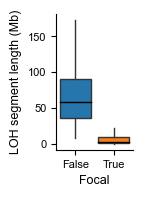

In [23]:
f, ax = plt.subplots(1, 1, figsize=(1.5, 2))
sns.boxplot(y=tcga_loh_segments.del_len/1000000, x=tcga_loh_segments.focal, showfliers=False, **gp.get_boxplot_props())
ax.set_ylabel('LOH segment length (Mb)'); ax.set_xlabel('Focal')
plt.tight_layout()

#### Map segments to genes

In [10]:
tcga_loh_map = util.map_segments_to_genes(tcga_loh_segments, passenger_genes, overlap_func=util.map_segment_full)

In [12]:
util.serialize_map(tcga_loh_map[tcga_loh_map.del_len>0], file_tcga_loh_map)

In [14]:
# Load from file
tcga_loh_map = util.deserialize_map(file_tcga_loh_map)

In [14]:
tcga_loh_map[:2]

,name,patient,ploidy,chr,startpos,endpos,nMajor,nMinor,del_len,focal,genes
0,TCGA-02-0001,TCGA-02-0001,2.3329,1,74386991,75378041,2,0,991050,True,"[1429, 127254, 8790, 127255, 51086, 127253]"
1,TCGA-02-0007,TCGA-02-0007,1.8988,1,203068384,205477439,16,0,2409055,True,"[134, 493, 1116, 1118, 6900, 25778, 55224, 233..."


In [16]:
print('N samples w/ LOH genes:', 
      tcga_loh_map[tcga_loh_map.genes.apply(lambda x: len(x)>0)]['patient'].nunique())
print('N samples w/ focal LOH genes:', 
      tcga_loh_map[tcga_loh_map.focal & tcga_loh_map.genes.apply(lambda x: len(x)>0)]['patient'].nunique())

N samples w/ LOH genes: 9624
N samples w/ focal LOH genes: 8878


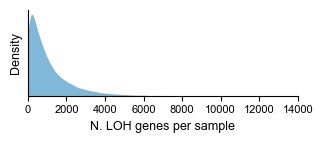

In [21]:
f, ax = plt.subplots(1, 1, figsize=(3.3, 1.5))
c = gp.get_color('blue')
df = util.count_dels_per_sample(tcga_loh_map[tcga_loh_map.focal], 'patient')
sns.kdeplot(df.n_genes, ax=ax, color=c, fill=True, lw=0, alpha=.5, clip=(0,13000))
ax.set_xlim([0,14000])
gp.set_axis_props(ax, xlabel='N. LOH genes per sample', show_yticklabels=False); plt.tight_layout()

#### Hemizygous deletions (LOH) per gene

In [24]:
tcga_loh = util.count_dels_per_gene(tcga_loh_map, passenger_genes)

In [25]:
tcga_focal_loh = util.count_dels_per_gene(tcga_loh_map[tcga_loh_map.focal], passenger_genes)

In [59]:
def draw_loh_boxplot(df, ax, title, offset, ylab=True):
    print('Median num samples w/ LOH: paralog=%d, singleton=%d' % 
          (df[df.paralog].n_del.median(), df[~df.paralog].n_del.median()))
    p=stats.mannwhitneyu(df[df.paralog].n_del, df[~df.paralog].n_del, alternative='two-sided')[1]
    sns.boxplot(data=df, x='paralog', y='n_del', ax=ax, **gp.get_boxplot_props(), showfliers=True, palette=['#ddd','#888'])
    gp.set_axis_props(ax, xlabel='Paralog', ylabel=('Samples w/ gene LOH' if ylab else ''), title=title)
    gp.draw_signif_MW(0, 1, df.n_del.max()+offset, p, ax, color=gp.get_color('grey'))
    ax.set_ylim([0,df.n_del.max()+offset])

Median num samples w/ LOH: paralog=1680, singleton=1699
Median num samples w/ LOH: paralog=479, singleton=483


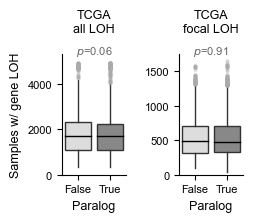

In [61]:
f, ax = plt.subplots(1, 2, figsize=(2.6, 2.3))
draw_loh_boxplot(tcga_loh, ax[0], 'TCGA\nall LOH\n', 400)
draw_loh_boxplot(tcga_focal_loh, ax[1], 'TCGA\nfocal LOH\n', 100, ylab=False)
plt.tight_layout(w_pad=1.5)
# plt.savefig('../figures/tcga_gene_loh.png', bbox_inches='tight', dpi=500, transparent=True)

### 2. ICGC

In [62]:
icgc_loh_segments = pd.read_csv(file_icgc_loh)

In [63]:
print('N samples w/ LOH:', icgc_loh_segments.samplename.nunique())
display(icgc_loh_segments[:1])

N samples w/ LOH: 1701


,chr,startpos,endpos,total_cn,major_cn,minor_cn,samplename,del_len,ploidy
0,2,194073132,196539045,2.0,2.0,0.0,0009b464-b376-4fbc-8a56-da538269a02f,2465913,3.355


In [64]:
chrom_info = pd.read_csv(file_chrom_info)
chrom_info = chrom_info[~chrom_info.chr.isin(['X','Y'])].astype({'chr':int})
chrom_info['half_arm1_len'] = chrom_info['centStart'] * 0.5
chrom_info['half_arm2_len'] = (chrom_info['size'] - chrom_info['centEnd']) * 0.5
chrom_info[:1]

,chr,centStart,centEnd,size,half_arm1_len,half_arm2_len
0,1,121535434,124535434,249250621,60767717.0,62357593.5


In [65]:
icgc_loh_segments = pd.merge(icgc_loh_segments, chrom_info[['chr','centEnd','half_arm1_len','half_arm2_len']])
icgc_loh_segments['focal'] = icgc_loh_segments.apply(
    lambda x: x.del_len < x.half_arm1_len if x.endpos < x.centEnd else x.del_len < x.half_arm2_len, axis=1)
icgc_loh_segments = icgc_loh_segments.drop(columns=['centEnd','half_arm1_len','half_arm2_len'])

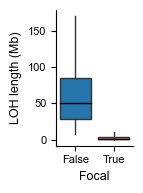

In [66]:
f, ax = plt.subplots(1, 1, figsize=(1.5, 2))
sns.boxplot(y=icgc_loh_segments.del_len/1000000, x=icgc_loh_segments.focal, showfliers=False, **gp.get_boxplot_props())
ax.set_ylabel('LOH length (Mb)'); ax.set_xlabel('Focal')
plt.tight_layout();

In [67]:
icgc_loh_map = util.map_segments_to_genes(icgc_loh_segments, passenger_genes, overlap_func=util.map_segment_full)

In [68]:
icgc_loh = util.count_dels_per_gene(icgc_loh_map, passenger_genes)
icgc_focal_loh = util.count_dels_per_gene(icgc_loh_map[icgc_loh_map.focal], passenger_genes)

Median num samples w/ LOH: paralog=225, singleton=231
Median num samples w/ LOH: paralog=78, singleton=79


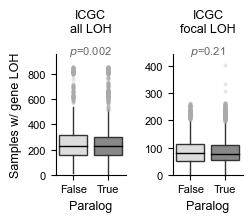

In [73]:
f, ax = plt.subplots(1, 2, figsize=(2.6, 2.3))
draw_loh_boxplot(icgc_loh, ax[0], 'ICGC\nall LOH\n', 100)
draw_loh_boxplot(icgc_focal_loh, ax[1], 'ICGC\nfocal LOH\n', 40, ylab=False)
plt.tight_layout(w_pad=1.5)
# plt.savefig('../figures/icgc_gene_loh.png', bbox_inches='tight', dpi=500, transparent=True)